In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.preprocessing import LabelEncoder

# Example dataset
data = pd.read_csv("/content/drive/MyDrive/Payments - Payments.csv")
bad_sender_data = pd.read_csv("/content/drive/MyDrive/bad_sender - bad_sender.csv")

# Creating a DataFrame from the dataset
df = pd.DataFrame(data)
df_bad_sender_original = pd.DataFrame(bad_sender_data)
df_bad_sender = pd.DataFrame(bad_sender_data)
combined_data = pd.concat([df['Sender'], df['Receiver'],df_bad_sender['Bad Sender']])

print(len(combined_data.value_counts()))

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform on combined data
encoded_combined_data = label_encoder.fit_transform(combined_data)

# Assign encoded values back to 'Sender' and 'Receiver' columns
df['Sender'] = encoded_combined_data[:len(df)]
df['Receiver'] = encoded_combined_data[len(df): 2*len(df)]
df_bad_sender['Bad Sender'] = encoded_combined_data[2*len(df): ]
print(df_bad_sender['Bad Sender'])
bad_sender_list = df_bad_sender['Bad Sender'].tolist()

reverse_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print(reverse_mapping)

# Creating a directed graph
G = nx.DiGraph()

aggregated_data = df.groupby(['Sender', 'Receiver']).agg({'Amount': 'sum'}).reset_index()

# Adding edges to the graph from the aggregated DataFrame
for _, row in aggregated_data.iterrows():
    sender = row['Sender']
    receiver = row['Receiver']
    G.add_edge(sender, receiver)

799
0     284
1     248
2     487
3     144
4     363
5      30
6     203
7      41
8      47
9     246
10    552
11    157
12      6
13     33
14    650
15     97
16    433
17    640
18     75
19    696
Name: Bad Sender, dtype: int64
{0: 1001, 1: 1002, 2: 1003, 3: 1004, 4: 1005, 5: 1006, 6: 1007, 7: 1008, 8: 1009, 9: 1010, 10: 1011, 11: 1012, 12: 1013, 13: 1014, 14: 1015, 15: 1016, 16: 1017, 17: 1018, 18: 1019, 19: 1020, 20: 1021, 21: 1022, 22: 1023, 23: 1024, 24: 1025, 25: 1026, 26: 1027, 27: 1028, 28: 1029, 29: 1030, 30: 1031, 31: 1032, 32: 1033, 33: 1034, 34: 1035, 35: 1036, 36: 1037, 37: 1038, 38: 1039, 39: 1040, 40: 1041, 41: 1042, 42: 1043, 43: 1044, 44: 1045, 45: 1046, 46: 1047, 47: 1048, 48: 1049, 49: 1050, 50: 1051, 51: 1052, 52: 1053, 53: 1054, 54: 1055, 55: 1056, 56: 1057, 57: 1058, 58: 1059, 59: 1060, 60: 1061, 61: 1062, 62: 1063, 63: 1064, 64: 1065, 65: 1066, 66: 1067, 67: 1068, 68: 1069, 69: 1070, 70: 1071, 71: 1072, 72: 1073, 73: 1074, 74: 1075, 75: 1076, 76: 1077, 77: 

In [ ]:
def create_transition_matrix_from_networkx(graph):
    num_nodes = len(graph.nodes)
    transition_matrix = [[0] * num_nodes for _ in range(num_nodes)]
    for edge in graph.edges:
        source = edge[0]
        target = edge[1]
        out_degree = len(list(graph.neighbors(source)))
        if out_degree != 0:
            transition_matrix[target][source] = 1 / out_degree

    return np.array(transition_matrix)

def create_inverse_transition_matrix_from_networkx(graph):
    num_nodes = len(graph.nodes)
    inverse_transition_matrix = [[0] * num_nodes for _ in range(num_nodes)]

    for edge in graph.edges:
        source = edge[0]
        target = edge[1]
        in_degree = graph.in_degree(target)
        if in_degree != 0:
            inverse_transition_matrix[source][target] = 1 / in_degree

    return np.array(inverse_transition_matrix)



def inverse_pagerank(inverse_transition_matrix, alpha, num_iterations):
    num_nodes = len(inverse_transition_matrix)
    initial_scores = np.ones(num_nodes) / num_nodes
    scores = initial_scores.copy()
    initial_scores = initial_scores.reshape(num_nodes, 1)
    scores=scores.reshape(num_nodes, 1)
    for _ in range(num_iterations):
        scores = alpha * np.dot(inverse_transition_matrix, scores) + (1 - alpha) * initial_scores

    return scores

def SelectSeed():
    inverse_transition_matrix = create_inverse_transition_matrix_from_networkx(G)
    inverse_pagerank_scores = inverse_pagerank(inverse_transition_matrix, 0.85, 20)
    return inverse_pagerank_scores

def Rank(node_list, seed_desirability):
    sorted_data = sorted(enumerate(seed_desirability),reverse = True, key=lambda x: x[1])
    print((sorted_data))
    sorted_indices = []
    for index, value in sorted_data:
        sorted_indices.append(index)
    return sorted_indices

def O(node_index):
    if node_index in bad_sender_list:
        return 0
    else:
        return 1


def TrustRank(transition_matrix, num_nodes, oracle_limit, alpha_bias, bias_iterations):
    # Evaluate seed-desirability of pages
    s = SelectSeed()
    #print(s)

    #Generate corresponding ordering
    sigma = Rank(list(range(0, num_nodes)), s)
    print(sigma)

    #Select good seeds
    d = np.zeros(num_nodes)
    for i in range(1, oracle_limit+1):
        if O(sigma[i-1]) == 1:
            d[sigma[i-1]] = 1

    #Normalize static score distribution vector
    #d = d/ np.linalg.norm(d)print(d)
    sum_d = sum(d)
    d =  [val / sum_d if val == 1 else 0 for val in d]
    d = np.array(d)
    d=d.reshape(num_nodes, 1)
    #print(d)

    #Compute TrustRank scores
    trust_rank = d
    for i in range(1, bias_iterations+1):
        trust_rank_prev = trust_rank
        trust_rank = (np.dot(transition_matrix, trust_rank) * alpha_bias) + ((1 - alpha_bias) * d)

        if(np.array_equal(trust_rank_prev, trust_rank)):
            print(f"break at : {i}")
            break
    return trust_rank

In [ ]:
# Create the transition matrix
transition_matrix = create_transition_matrix_from_networkx(G)
#print((transition_matrix))
trust_rank_values = TrustRank(transition_matrix, len(G.nodes), 40, 0.85, 100)
print(trust_rank_values)

[(290, array([0.00159736])), (131, array([0.00149071])), (365, array([0.00141406])), (144, array([0.00137675])), (135, array([0.00132527])), (78, array([0.0013202])), (36, array([0.00131424])), (38, array([0.00120251])), (33, array([0.00118441])), (106, array([0.00114588])), (203, array([0.00113752])), (50, array([0.0011278])), (334, array([0.00111525])), (291, array([0.00109439])), (15, array([0.00108236])), (22, array([0.00106958])), (6, array([0.00106756])), (617, array([0.00101923])), (213, array([0.00101483])), (475, array([0.00099238])), (248, array([0.00098938])), (41, array([0.00090651])), (34, array([0.00088722])), (123, array([0.00087669])), (216, array([0.00085646])), (307, array([0.00085402])), (139, array([0.00080712])), (48, array([0.00080487])), (198, array([0.00080256])), (97, array([0.00078558])), (612, array([0.0007779])), (253, array([0.00077073])), (487, array([0.00076426])), (678, array([0.0007603])), (161, array([0.00076011])), (236, array([0.00075222])), (323, ar

In [ ]:
sorted_trust_ranks = sorted(enumerate(trust_rank_values), reverse = True, key=lambda x: x[1])
print((sorted_trust_ranks))


sorted_trust_ranks_with_replacement = [(reverse_mapping[index], value) if index in reverse_mapping else (index, value) for index, value in sorted_trust_ranks]
sorted_indices_trust_ranks = []
for index, value in sorted_trust_ranks_with_replacement:
    sorted_indices_trust_ranks.append(index)

#print(sorted_indices_trust_ranks)
print((sorted_trust_ranks_with_replacement))

[(93, array([0.01371308])), (36, array([0.01259866])), (135, array([0.01206242])), (119, array([0.01190559])), (167, array([0.01108781])), (198, array([0.01045283])), (236, array([0.00985429])), (40, array([0.00942464])), (103, array([0.00899221])), (15, array([0.00895473])), (290, array([0.00893684])), (194, array([0.00886472])), (78, array([0.00883811])), (48, array([0.00836768])), (106, array([0.00822918])), (213, array([0.00814535])), (334, array([0.00800789])), (141, array([0.00762515])), (87, array([0.00730543])), (39, array([0.00727042])), (85, array([0.00715487])), (38, array([0.00712983])), (22, array([0.00702489])), (203, array([0.0069601])), (307, array([0.00695667])), (34, array([0.00665616])), (6, array([0.00663707])), (41, array([0.00641441])), (291, array([0.00637511])), (168, array([0.00625088])), (75, array([0.00616254])), (42, array([0.00607323])), (353, array([0.00568298])), (216, array([0.00558961])), (214, array([0.00554575])), (123, array([0.00540563])), (130, arr

In [ ]:

bad_sender_trust_rank_values = []

for index, value in sorted_trust_ranks_with_replacement:
    if index in df_bad_sender_original['Bad Sender'].values.tolist():
        bad_sender_trust_rank_values.append(value)
        print(f'Trust score of Bad sender: {index}, {value}')

Trust score of Bad sender: 1210, [0.0069601]
Trust score of Bad sender: 1007, [0.00663707]
Trust score of Bad sender: 1042, [0.00641441]
Trust score of Bad sender: 1076, [0.00616254]
Trust score of Bad sender: 1034, [0.00486553]
Trust score of Bad sender: 1099, [0.00331471]
Trust score of Bad sender: 1147, [0.00276104]
Trust score of Bad sender: 1048, [0.00098601]
Trust score of Bad sender: 1489, [0.00089828]
Trust score of Bad sender: 1161, [0.00076095]
Trust score of Bad sender: 1836, [0.00025594]
Trust score of Bad sender: 1031, [0.00013281]
Trust score of Bad sender: 1256, [0.]
Trust score of Bad sender: 1259, [0.]
Trust score of Bad sender: 1303, [0.]
Trust score of Bad sender: 1393, [0.]
Trust score of Bad sender: 1562, [0.]
Trust score of Bad sender: 1668, [0.]
Trust score of Bad sender: 1821, [0.]
Trust score of Bad sender: 1944, [0.]


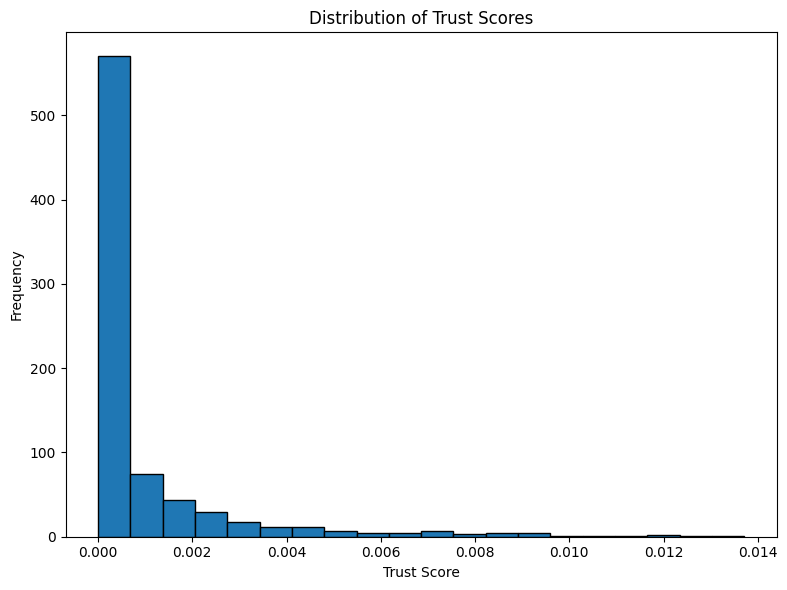

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(trust_rank_values, bins=20, edgecolor='black')
plt.xlabel('Trust Score')
plt.ylabel('Frequency')
plt.title('Distribution of Trust Scores')
plt.tight_layout()
plt.savefig('trust_score_distribution.png')
plt.show()

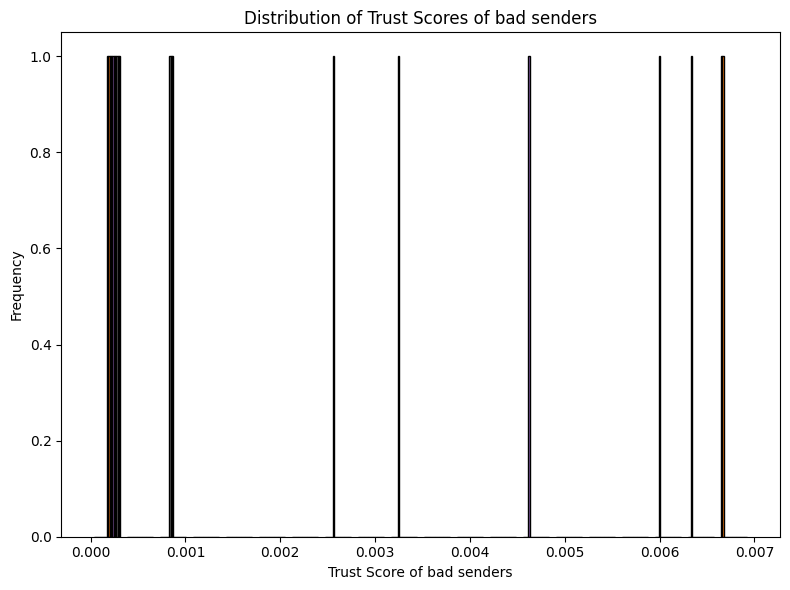

In [ ]:
import matplotlib.pyplot as plt



plt.figure(figsize=(8, 6))
plt.hist(bad_sender_trust_rank_values, bins=20, edgecolor='black')
plt.xlabel('Trust Score of bad senders')
plt.ylabel('Frequency')
plt.title('Distribution of Trust Scores of bad senders')
plt.tight_layout()
plt.savefig('trust_score_distribution.png')
plt.show()